# KNN Matching and Bias Correction

**Chapter 10, Section 3**

This notebook covers K-nearest neighbors matching and the curse of dimensionality problem.

## Table of Contents
1. [Intuition](#intuition) - KNN as matching estimator
2. [Formal Treatment](#formal) - Matching bias and curse of dimensionality
3. [Numeric Demonstration](#numeric) - Bias in high dimensions
4. [Implementation](#implementation) - Bias-corrected matching
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### K-Nearest Neighbors Matching

Instead of finding *one* exact match, KNN finds the *K closest* control units:

$$\hat{Y}_i(0) = \frac{1}{K} \sum_{j \in \mathcal{N}_K(i)} Y_j$$

where $\mathcal{N}_K(i)$ is the set of K nearest control units to treated unit $i$.

**Why use K > 1?**
- Reduces variance (average of K outcomes)
- More robust to outliers
- Trade-off: Introduces bias if matches are imperfect

### The Curse of Dimensionality

As the number of covariates increases, matching becomes harder:

| # Features | Neighbor Distance | Match Quality |
|------------|------------------|---------------|
| 1 | Small | Excellent |
| 5 | Moderate | Good |
| 10 | Large | Poor |
| 20 | Very large | Very poor |

**Why?** In high dimensions, all points become approximately equidistant. The "nearest" neighbor may not be close at all.

---

In [2]:
# Load medicine data
med = load_facure_data("medicine_impact_recovery.csv")

print(f"Data: {len(med)} patients")
print(f"Treatment: {med['medication'].mean():.1%} received medication")
print(f"\nFeatures: sex, age, severity")
med.head()

Data: 20000 patients
Treatment: 34.6% received medication

Features: sex, age, severity


,sex,age,severity,medication,recovery
0,0,35.0491,0.8877,1,31
1,1,41.5803,0.8998,1,49
2,1,28.1275,0.4863,0,38
3,1,36.3750,0.3231,0,35
4,0,25.0917,0.2090,0,15


In [3]:
# Demonstrate curse of dimensionality with simulated data
def simulate_nearest_neighbor_distance(n_samples=1000, n_features_list=[1, 2, 5, 10, 20, 50]):
    """Show how nearest neighbor distance grows with dimensions."""
    np.random.seed(42)
    results = []
    
    for n_features in n_features_list:
        # Generate random data
        X = np.random.randn(n_samples, n_features)
        
        # Find nearest neighbor distances
        nn = NearestNeighbors(n_neighbors=2)  # 2 because first is self
        nn.fit(X)
        distances, _ = nn.kneighbors(X)
        
        # Second column is distance to nearest (non-self) neighbor
        nn_distances = distances[:, 1]
        
        results.append({
            'n_features': n_features,
            'mean_distance': nn_distances.mean(),
            'median_distance': np.median(nn_distances),
            'max_distance': nn_distances.max()
        })
    
    return pd.DataFrame(results)

curse_results = simulate_nearest_neighbor_distance()

print("CURSE OF DIMENSIONALITY:")
print("=" * 60)
print("Nearest neighbor distance grows with dimension count:")
print(curse_results.to_string(index=False))

CURSE OF DIMENSIONALITY:
Nearest neighbor distance grows with dimension count:
 n_features  mean_distance  median_distance  max_distance
          1         0.0045           0.0013        0.7739
          2         0.0774           0.0576        0.9982
          5         0.7210           0.6766        2.4571
         10         1.8161           1.7832        3.7404
         20         3.5887           3.5810        5.3284
         50         7.2456           7.2307        9.0031


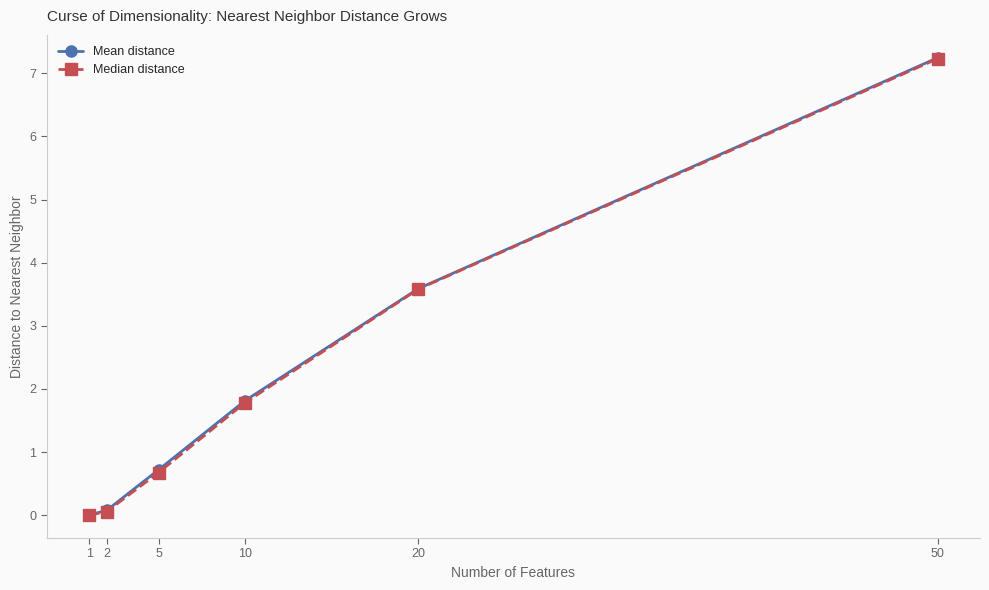

With more features, 'nearest' neighbors aren't very near at all!


In [4]:
# Visualize the curse
fig, ax = create_tufte_figure(figsize=(10, 6))

ax.plot(curse_results['n_features'], curse_results['mean_distance'], 
        'o-', color=COLORS['blue'], linewidth=2, markersize=8, label='Mean distance')
ax.plot(curse_results['n_features'], curse_results['median_distance'], 
        's--', color=COLORS['red'], linewidth=2, markersize=8, label='Median distance')

set_tufte_title(ax, "Curse of Dimensionality: Nearest Neighbor Distance Grows")
set_tufte_labels(ax, "Number of Features", "Distance to Nearest Neighbor")
ax.legend(frameon=False)
ax.set_xticks(curse_results['n_features'])

plt.tight_layout()
plt.show()

print("With more features, 'nearest' neighbors aren't very near at all!")

---

## Formal Treatment

### Matching Bias

Even with nearest neighbor matching, there's residual bias because matches aren't exact.

**Definition** (Matching Bias):

For treated unit $i$ matched to control unit $j(i)$:

$$\text{Bias}_i = E[Y_j(0) | X_{j(i)}] - E[Y_i(0) | X_i]$$

If $X_{j(i)} \neq X_i$, and the outcome depends on $X$, then this bias is non-zero.

### Abadie-Imbens Bias Correction

**Key insight**: Use regression to adjust for the covariate difference.

**Step 1**: Estimate outcome model on controls:
$$\hat{\mu}_0(x) = \hat{\alpha} + \hat{\beta}'x$$

**Step 2**: Compute bias-corrected counterfactual:
$$\hat{Y}_i(0)^{BC} = Y_{j(i)} + [\hat{\mu}_0(X_i) - \hat{\mu}_0(X_{j(i)})]$$

The correction term adjusts for the covariate difference:
$$\hat{\mu}_0(X_i) - \hat{\mu}_0(X_{j(i)}) = \hat{\beta}'(X_i - X_{j(i)})$$

### ATT with Bias Correction

$$\hat{\tau}_{ATT}^{BC} = \frac{1}{N_1} \sum_{i: T_i=1} \left[ Y_i - \hat{Y}_i(0)^{BC} \right]$$

---

In [5]:
# Prepare data for matching
features = ['sex', 'age', 'severity']
X = med[features].values
Y = med['recovery'].values
T = med['medication'].values

# Split by treatment
X_treated = X[T == 1]
X_control = X[T == 0]
Y_treated = Y[T == 1]
Y_control = Y[T == 0]

print(f"Treated: {len(X_treated)} patients")
print(f"Control: {len(X_control)} patients")

# Standardize features
scaler = StandardScaler()
X_control_std = scaler.fit_transform(X_control)
X_treated_std = scaler.transform(X_treated)

Treated: 6924 patients
Control: 13076 patients


In [6]:
def knn_matching_att(X_treated, X_control, Y_treated, Y_control, K=1):
    """
    Estimate ATT using K-nearest neighbor matching.
    """
    nn = NearestNeighbors(n_neighbors=K, metric='euclidean')
    nn.fit(X_control)
    
    # Find K nearest controls for each treated
    distances, indices = nn.kneighbors(X_treated)
    
    # Counterfactual = average of K matched control outcomes
    counterfactuals = Y_control[indices].mean(axis=1)
    
    # Individual treatment effects
    effects = Y_treated - counterfactuals
    att = effects.mean()
    se = effects.std() / np.sqrt(len(effects))
    
    return {
        'ATT': att,
        'SE': se,
        'mean_distance': distances.mean(),
        'effects': effects,
        'match_indices': indices
    }

# Compare different K values
print("KNN MATCHING WITH DIFFERENT K:")
print("=" * 60)

for K in [1, 3, 5, 10]:
    result = knn_matching_att(X_treated_std, X_control_std, Y_treated, Y_control, K=K)
    print(f"K={K:2d}: ATT = {result['ATT']:.2f} (SE = {result['SE']:.2f}), mean distance = {result['mean_distance']:.3f}")

KNN MATCHING WITH DIFFERENT K:
K= 1: ATT = -7.58 (SE = 0.04), mean distance = 0.436
K= 3: ATT = -7.26 (SE = 0.04), mean distance = 0.507


K= 5: ATT = -7.07 (SE = 0.04), mean distance = 0.542
K=10: ATT = -6.78 (SE = 0.04), mean distance = 0.595


---

## Numeric Demonstration

### Bias-Corrected Matching

In [7]:
def bias_corrected_matching(X_treated, X_control, Y_treated, Y_control, K=1):
    """
    Abadie-Imbens bias-corrected matching estimator.
    
    Step 1: Find K nearest neighbors
    Step 2: Estimate outcome model on control group
    Step 3: Adjust counterfactual for covariate differences
    """
    # Step 1: Find nearest neighbors
    nn = NearestNeighbors(n_neighbors=K, metric='euclidean')
    nn.fit(X_control)
    distances, indices = nn.kneighbors(X_treated)
    
    # Step 2: Estimate outcome model on control group
    outcome_model = LinearRegression()
    outcome_model.fit(X_control, Y_control)
    
    # Step 3: Bias correction
    corrected_effects = []
    uncorrected_effects = []
    
    for i in range(len(X_treated)):
        # Average outcome of K matched controls
        matched_outcomes = Y_control[indices[i]].mean()
        
        # Uncorrected counterfactual
        uncorrected = Y_treated[i] - matched_outcomes
        uncorrected_effects.append(uncorrected)
        
        # Bias correction term
        # For each match, compute predicted outcome difference
        mu_treated = outcome_model.predict(X_treated[i:i+1])[0]
        mu_matched = outcome_model.predict(X_control[indices[i]]).mean()
        
        # Bias-corrected counterfactual
        correction = mu_treated - mu_matched
        corrected_counterfactual = matched_outcomes + correction
        corrected = Y_treated[i] - corrected_counterfactual
        corrected_effects.append(corrected)
    
    uncorrected_effects = np.array(uncorrected_effects)
    corrected_effects = np.array(corrected_effects)
    
    return {
        'ATT_uncorrected': uncorrected_effects.mean(),
        'SE_uncorrected': uncorrected_effects.std() / np.sqrt(len(uncorrected_effects)),
        'ATT_corrected': corrected_effects.mean(),
        'SE_corrected': corrected_effects.std() / np.sqrt(len(corrected_effects)),
        'mean_correction': np.abs(corrected_effects - uncorrected_effects).mean()
    }

In [8]:
# Compare uncorrected vs bias-corrected
print("BIAS CORRECTION COMPARISON:")
print("=" * 70)

# Naive estimate
naive = Y_treated.mean() - Y_control.mean()
print(f"\nNaive (no matching): ATT = {naive:.2f}")

print(f"\n{'K':<5} {'Uncorrected ATT':<18} {'Corrected ATT':<18} {'Mean Correction'}")
print("-" * 70)

for K in [1, 3, 5, 10]:
    result = bias_corrected_matching(X_treated_std, X_control_std, Y_treated, Y_control, K=K)
    print(f"{K:<5} {result['ATT_uncorrected']:<18.2f} {result['ATT_corrected']:<18.2f} {result['mean_correction']:.3f}")

BIAS CORRECTION COMPARISON:

Naive (no matching): ATT = 16.90

K     Uncorrected ATT    Corrected ATT      Mean Correction
----------------------------------------------------------------------


1     -7.58              -12.35             4.919


3     -7.26              -12.81             5.596


5     -7.07              -13.01             5.972


10    -6.78              -13.28             6.513


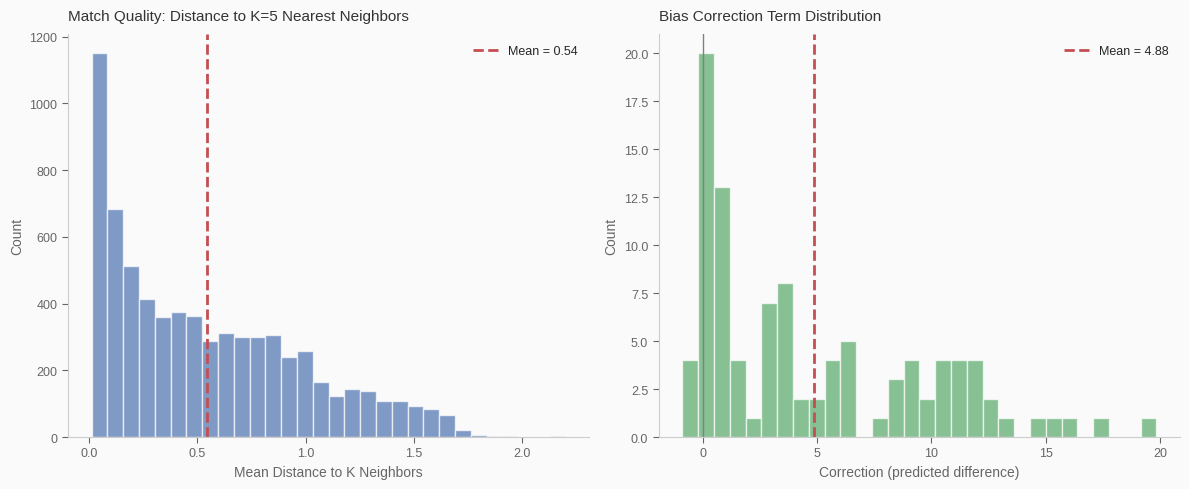

Mean correction magnitude: 4.936
Positive correction = treated unit predicted higher outcome than matched controls


In [9]:
# Visualize bias correction
fig, axes = create_tufte_figure(ncols=2, figsize=(12, 5))

# Get detailed results for K=5
K = 5
nn = NearestNeighbors(n_neighbors=K, metric='euclidean')
nn.fit(X_control_std)
distances, indices = nn.kneighbors(X_treated_std)

# For visualization, show a subset
np.random.seed(42)
viz_idx = np.random.choice(len(X_treated), 100, replace=False)

# Left: Match distances histogram
ax = axes[0]
mean_match_distances = distances.mean(axis=1)
ax.hist(mean_match_distances, bins=30, alpha=0.7, color=COLORS['blue'], edgecolor='white')
ax.axvline(mean_match_distances.mean(), color=COLORS['red'], linestyle='--', linewidth=2, 
           label=f'Mean = {mean_match_distances.mean():.2f}')
set_tufte_title(ax, f"Match Quality: Distance to K={K} Nearest Neighbors")
set_tufte_labels(ax, "Mean Distance to K Neighbors", "Count")
ax.legend(frameon=False)

# Right: Correction magnitude
ax = axes[1]
outcome_model = LinearRegression()
outcome_model.fit(X_control_std, Y_control)

corrections = []
for i in viz_idx:
    mu_treated = outcome_model.predict(X_treated_std[i:i+1])[0]
    mu_matched = outcome_model.predict(X_control_std[indices[i]]).mean()
    corrections.append(mu_treated - mu_matched)
corrections = np.array(corrections)

ax.hist(corrections, bins=30, alpha=0.7, color=COLORS['green'], edgecolor='white')
ax.axvline(corrections.mean(), color=COLORS['red'], linestyle='--', linewidth=2,
           label=f'Mean = {corrections.mean():.2f}')
ax.axvline(0, color='gray', linestyle='-', linewidth=1)
set_tufte_title(ax, "Bias Correction Term Distribution")
set_tufte_labels(ax, "Correction (predicted difference)", "Count")
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

print(f"Mean correction magnitude: {np.abs(corrections).mean():.3f}")
print("Positive correction = treated unit predicted higher outcome than matched controls")

---

## Implementation

### sklearn KNeighborsRegressor

In [10]:
# Using sklearn's KNeighborsRegressor for matching
def sklearn_knn_matching(X_treated, X_control, Y_treated, Y_control, K=1):
    """
    Use sklearn KNeighborsRegressor for matching.
    This directly predicts counterfactual outcomes.
    """
    knn = KNeighborsRegressor(n_neighbors=K, weights='uniform')
    knn.fit(X_control, Y_control)
    
    # Predict counterfactuals for treated units
    counterfactuals = knn.predict(X_treated)
    
    # ATT
    effects = Y_treated - counterfactuals
    att = effects.mean()
    se = effects.std() / np.sqrt(len(effects))
    
    return {'ATT': att, 'SE': se}

# Compare with our implementation
print("SKLEARN VS MANUAL KNN MATCHING:")
print("=" * 60)

for K in [1, 5, 10]:
    sklearn_result = sklearn_knn_matching(X_treated_std, X_control_std, Y_treated, Y_control, K)
    manual_result = knn_matching_att(X_treated_std, X_control_std, Y_treated, Y_control, K)
    
    print(f"K={K:2d}: sklearn ATT = {sklearn_result['ATT']:.4f}, manual ATT = {manual_result['ATT']:.4f}")

print("\nBoth implementations give identical results (as expected).")

SKLEARN VS MANUAL KNN MATCHING:
K= 1: sklearn ATT = -7.5817, manual ATT = -7.5817
K= 5: sklearn ATT = -7.0693, manual ATT = -7.0693
K=10: sklearn ATT = -6.7834, manual ATT = -6.7834

Both implementations give identical results (as expected).


In [11]:
# Final summary comparing all methods
print("\nFINAL COMPARISON:")
print("=" * 70)
print(f"{'Method':<35} {'ATT':<12} {'SE':<12} {'95% CI'}")
print("-" * 70)

# Naive
naive_att = Y_treated.mean() - Y_control.mean()
naive_se = np.sqrt(Y_treated.var()/len(Y_treated) + Y_control.var()/len(Y_control))
print(f"{'Naive (no matching)':<35} {naive_att:<12.2f} {naive_se:<12.2f} [{naive_att-1.96*naive_se:.2f}, {naive_att+1.96*naive_se:.2f}]")

# KNN K=1
r1 = knn_matching_att(X_treated_std, X_control_std, Y_treated, Y_control, K=1)
print(f"{'KNN (K=1)':<35} {r1['ATT']:<12.2f} {r1['SE']:<12.2f} [{r1['ATT']-1.96*r1['SE']:.2f}, {r1['ATT']+1.96*r1['SE']:.2f}]")

# KNN K=5
r5 = knn_matching_att(X_treated_std, X_control_std, Y_treated, Y_control, K=5)
print(f"{'KNN (K=5)':<35} {r5['ATT']:<12.2f} {r5['SE']:<12.2f} [{r5['ATT']-1.96*r5['SE']:.2f}, {r5['ATT']+1.96*r5['SE']:.2f}]")

# Bias-corrected K=5
bc5 = bias_corrected_matching(X_treated_std, X_control_std, Y_treated, Y_control, K=5)
print(f"{'Bias-corrected KNN (K=5)':<35} {bc5['ATT_corrected']:<12.2f} {bc5['SE_corrected']:<12.2f} [{bc5['ATT_corrected']-1.96*bc5['SE_corrected']:.2f}, {bc5['ATT_corrected']+1.96*bc5['SE_corrected']:.2f}]")


FINAL COMPARISON:
Method                              ATT          SE           95% CI
----------------------------------------------------------------------
Naive (no matching)                 16.90        0.17         [16.56, 17.23]


KNN (K=1)                           -7.58        0.04         [-7.65, -7.51]


KNN (K=5)                           -7.07        0.04         [-7.14, -7.00]


Bias-corrected KNN (K=5)            -13.01       0.03         [-13.07, -12.94]


---

## Interview Appendix

### Practice Questions

**Q1: What is matching bias and how do you correct it?**

<details>
<summary>Solution</summary>

**Matching Bias** occurs because nearest-neighbor matches are imperfect:

$$\text{Bias}_i = E[Y(0) | X_{matched}] - E[Y(0) | X_{treated}]$$

Even the "nearest" control unit has different covariate values, leading to systematic differences in expected outcomes.

**Abadie-Imbens Bias Correction**:

1. Estimate outcome model on controls: $\hat{\mu}_0(x)$
2. Compute correction term: $\hat{\mu}_0(X_i) - \hat{\mu}_0(X_{j(i)})$
3. Adjust counterfactual: $\hat{Y}_i(0)^{BC} = Y_{j(i)} + \text{correction}$

**Intuition**: The correction estimates how much the outcome would differ if the matched control had the same covariates as the treated unit.

**When to use**:
- Always with approximate matching
- Especially important with many covariates (curse of dimensionality)
- Less necessary with very close matches

</details>

**Q2: What is the curse of dimensionality in matching?**

<details>
<summary>Solution</summary>

**Definition**: As the number of covariates increases, the "nearest" neighbor becomes farther away.

**Why it happens**:
1. Volume of space grows exponentially with dimensions
2. Data points become increasingly sparse
3. All points become approximately equidistant

**Consequences for matching**:
- Poor match quality (large covariate differences)
- Increased matching bias
- Estimates become unreliable

**Solutions**:
1. **Propensity score**: Match on 1D score instead of full X
2. **Feature selection**: Use only the most important confounders
3. **Bias correction**: Abadie-Imbens adjustment
4. **Coarsening**: Bin continuous variables (Coarsened Exact Matching)
5. **Regularization**: Use ML methods that handle high dimensions

**Rule of thumb**: Be cautious with >10 continuous covariates in standard matching.

</details>

**Q3: How do you choose K in KNN matching?**

<details>
<summary>Solution</summary>

**Trade-off**:
- **K=1**: Lowest bias (closest match), highest variance
- **Large K**: Lower variance (averaged), higher bias (worse matches)

**Practical guidance**:

1. **Start with K=1** for unbiased estimates if matches are close
2. **Increase K (3-5)** if:
   - Variance is high
   - Many similar controls available
   - Bias correction is used

3. **Use cross-validation** to select K:
   - Predict outcomes using different K
   - Choose K with best predictive accuracy

4. **Check sensitivity**:
   - Run analysis with K=1, 3, 5, 10
   - Results should be stable across K

**With bias correction**: K matters less because bias is explicitly adjusted.

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 10.

[^2]: Abadie, A., & Imbens, G. W. (2006). Large sample properties of matching estimators for average treatment effects. *Econometrica*, 74(1), 235-267.

[^3]: Abadie, A., & Imbens, G. W. (2011). Bias-corrected matching estimators for average treatment effects. *Journal of Business & Economic Statistics*, 29(1), 1-11.

[^4]: Cross-reference: Propensity score as solution to curse of dimensionality in `11_propensity_score/01_balancing_score.ipynb`